In [1]:
### 

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.options.display.max_rows = 999
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from xgboost import XGBRegressor

In [3]:
city_name = 'iq'

xgbTrain = pd.read_csv("./data/ensamble_xgb_" + str('iq') + ".csv"  ).drop('total_cases',axis = 1).set_index('week_start_date')
rfTrain = pd.read_csv("./data/ensamble_rf_" + str('iq') + ".csv"  ).drop('total_cases',axis = 1).set_index('week_start_date')
Ensamble_train = xgbTrain.merge(rfTrain ,left_index = True,right_index = True)
Ensamble_train  .columns = ['xgb','rf']

xgbTest = pd.read_csv("./data/0127_xgb_" + str('iq') + ".csv",header = None  )
rfTest = pd.read_csv("./data/0127_rf_" + str('iq') + ".csv",header = None  )

xgbTest .columns = ['week_start_date','xgb']
xgbTest =xgbTest .set_index('week_start_date')

rfTest .columns = ['week_start_date','rf']
rfTest = rfTest.set_index('week_start_date')
Ensamble_test =  xgbTest .merge(rfTest ,left_index = True,right_index = True)

In [6]:


 


TargetTrain = pd.read_csv('./data/dengue_labels_train.csv'  )
FeatureTrain = pd.read_csv('./data/dengue_features_train.csv',parse_dates = ['week_start_date'])
penel = FeatureTrain .merge(TargetTrain,on = ['city','year','weekofyear']) 
penel  = penel .loc[penel .city =='iq'].set_index('week_start_date')
penel = penel.loc[:,['total_cases']]

In [7]:


data_selected = penel.merge(Ensamble_train ,left_index = True,right_index = True) 
train_len = len(data_selected )

 
#modelTest .index =pd.to_datetime( modelTest.index)
#data_selected = pd.concat([data_selected ,modelTest ],sort = False) 

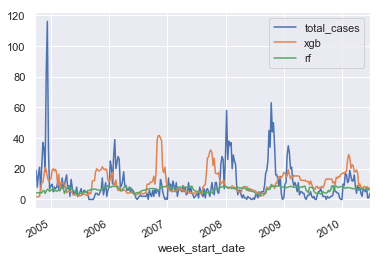

In [8]:
data_selected.iloc[-300:].plot()

In [9]:
abs( data_selected.iloc[:,1:3].mean(1).ravel() -  data_selected.iloc[:,0] .ravel() ).mean()

7.459512905942432

In [11]:
import statsmodels.api as sm
Y = data_selected.iloc[:,0].clip(0,60)
X = data_selected.iloc[:,1:3]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.tvalues

const    1.860701
xgb     -0.067047
rf       2.842755
dtype: float64

In [12]:
X_test = sm.add_constant( Ensamble_test)
X_test .dot(results.params).round().to_csv('./data/01_28_emsamble_iq.csv')

D:\Anaconda3\envs\interview_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


### look at target first

In [ ]:
from sklearn.model_selection import KFold
data = data_selected.copy()#.iloc[:train_len ].dropna()
#data_test = data_selected.copy().iloc[train_len: ].fillna(method = 'ffill') .fillna(method = 'bfill').replace(np.nan,0)
kf = KFold(n_splits=4, random_state=None, shuffle=False)

expr = """total_cases ~  -1 +  """
drops = ['total_cases' ]
for name in data.drop(drops,axis = 1).columns:
    expr +=    name + ' + '
expr=  expr[:-2]

maes = []
models = []
test_xs = []
test_ys = []

    
for train_index, test_index in kf.split(data):
    
    df_train = data.iloc[train_index,:]
    df_test  = data.iloc[test_index,:]
    
    train_y,  train_X = dmatrices(expr, df_train, return_type='dataframe')
    test_y,  test_X = dmatrices(expr, df_test, return_type='dataframe')
    
    test_xs.append(test_X)
    test_ys.append(test_y)
    
    model =XGBRegressor(  base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=10, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1 )
    train_y = (train_y.iloc[:,0].clip(0,100) )  .dropna()
    train_X = train_X.loc[train_y.index]
    model.fit( train_X,train_y   )
    pred_res = model.predict(test_X )
    pred_res = pd.Series(pred_res,index =df_test.index )
    models.append(model)
    maes .append(abs(test_y.values.ravel()- pred_res.values.ravel()).mean())
    
 

In [ ]:
ith =0
plt.plot(  test_ys[ith] )
plt.plot(pd.Series(models[ith].predict(test_xs[ith] ),index = test_ys[ith].index)   )
 
np.mean(maes) 

In [ ]:
df_total  = data 
    
total_y,  total_X = dmatrices(expr, df_total, return_type='dataframe')
model = RandomForestRegressor(n_estimators=400, max_depth=6,min_samples_split = 8,min_samples_leaf =32,
                                         criterion='mae', warm_start=True)
model.fit( total_X ,total_y.iloc[:,0].clip(0,70))

In [ ]:
 
submit_y,  submit_X = dmatrices(expr, data_test , return_type='dataframe')

pd.Series(np.round(model.predict(submit_X)).astype(int),index = submit_y.index).\
to_csv("./data/0126_ensamble_" + str(city_name) + ".csv",header = False)

In [ ]:
pd.Series(np.round(model.predict(submit_X)).astype(int),index = submit_y.index).plot()

### Based model